In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import seaborn as sns

import tifffile

from scipy import stats
from skimage.filters import threshold_li, threshold_otsu

In [2]:
##### reading necessary files ####

M = pd.read_csv('./_Hippo_output_v1/Umap120hippo.csv',header=None,)
Cell = pd.read_csv('./_Hippo_output_v1/hippoCoM.csv',header=None,)
annot = pd.read_csv("./_Hippo_output_v1/Hippo120V2.csv",header=None)[1]

print('M: row=cell,col=genes matrix:',M.shape)
print('Cell: XYZ space coordinate of cells:',Cell.shape)
print('annot: gene names:',annot.shape)

M: row=cell,col=genes matrix: (19871, 120)
Cell: XYZ space coordinate of cells: (19871, 3)
annot: gene names: (120,)


In [3]:
######### three input files into one matrix #######
M.columns = annot ### label columns with genes
Cell.columns = ['x','y','z']
m = pd.concat([M,Cell],axis=1) ### add xyz to the matrix
print(m.shape)
m.columns = m.columns.str.replace('\'','') # remove '' from columns names
m

(19871, 123)


,Egr1,Fos,Arc,Tiam1,Ptgs2,Homer1,Spock1,St8sia5,Tgfb2,Sgk1,...,Adgra1,Grm1,Erbb4,Adora1,Dlk1,S1pr1,Dlk1_1,x,y,z
0,0,1,1,0,1,1,0,2,1,0,...,3,0,2,2,0,1,1,1183.804717,458.685744,10.371141
1,1,0,1,1,0,0,0,1,1,1,...,0,0,1,0,0,1,0,1217.607923,511.970856,11.680783
2,2,1,1,0,1,2,0,1,1,0,...,4,1,4,3,1,5,3,1285.660597,548.370069,13.838524
3,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1126.445389,555.005819,10.599821
4,1,1,1,0,1,1,0,2,2,0,...,3,0,1,2,0,1,1,1157.884907,608.468298,10.706409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19866,0,0,0,0,0,3,0,0,0,0,...,6,0,2,7,0,6,6,3785.655154,1225.522240,106.051282
19867,0,0,0,0,0,3,0,0,0,0,...,6,0,2,5,0,1,6,3932.259687,1037.076669,105.089035
19868,0,0,0,0,0,6,0,0,0,0,...,16,0,2,22,0,0,22,3941.674599,1062.569356,105.942542
19869,0,0,0,0,1,0,0,0,0,0,...,6,1,3,6,1,3,7,3890.459474,1161.030059,106.836822


In [4]:
def filter_matrix_hippo(m_xyz_df, tcell, tgene, norm=False, ForAssignment=False):
    mx = m_xyz_df.iloc[:,:-3]
    mcell = m_xyz_df[['x','y','z']]
    
    
    ### genes with low counts ####
    gene_rm = np.sum(mx,axis=0)<=tgene
    # print(mx.columns[gene_rm])
    print('removed gene count:', str(np.sum(gene_rm)))        
    
    ### remove genes ##
    mx_filter_gene = mx.iloc[:,~gene_rm.values]

    # cells with low count #
    cell_rm = np.sum(mx_filter_gene,axis=1)<=tcell   # threshold cells after removing genes
    mx_filter = mx_filter_gene.iloc[~cell_rm.values,:]
    print('removed cell count:', str(np.sum(cell_rm)))
    ##### normalize ####
    if ForAssignment==True:
        mx_filter = mx.iloc[~cell_rm.values,:]
        print('no gene removed')  # if true, remove no gene, in case we want to do some other analysis with them
    
    if norm==True:
        mx_norm = mx_filter.div(mx_filter.sum(axis=1), axis=0)*10_000
    else:
        mx_norm = mx_filter
    #######################
    mcell_filter = mcell.iloc[~cell_rm.values,:]
    o = pd.concat([mx_norm,mcell_filter],axis=1).reset_index(drop=True)
    
    # we will keep 4 things
    # 1. filtered matrix, with reset index
    # 2. boolean of kept cells in original index
    # 3. indices of kept cells (=npwhere.boolean of 2)
    # 4. indices of removed cells
    return o.reset_index(drop=True), (~cell_rm.values), np.where((~cell_rm.values))[0], np.where((cell_rm.values))[0]

##### thresholding gene ####
dat = m.iloc[:,:-3]
x0 = np.log1p(np.sum(dat,axis=0).to_numpy()) #### sum per gene, in log space
print(x0.shape)
thresh_g = threshold_li(x0)
Thresh_gene = np.expm1(thresh_g) #### thresh_g is in log space, so revert back to linear space

##### thresholding cell ####
Thresh_cell = 10    #### 

m_filter,m_filter_boolcell,m_filter_ind,m_filter_indnull = filter_matrix_hippo(m,tcell=Thresh_cell,tgene=Thresh_gene,norm=False,ForAssignment=False)
m_norm,m_norm_boolcell,m_norm_ind,m_norm_indnull = filter_matrix_hippo(m,tcell=Thresh_cell,tgene=Thresh_gene,norm=True,ForAssignment=False)

(120,)
removed gene count: 59
removed cell count: 1484
removed gene count: 59
removed cell count: 1484


In [5]:
######## read the cluster information from previous #######
embedding_labels = pd.read_csv('./hippo_umap_notebook/li_hippo_min10_neighbor200_c320_s18_UMAP_labels_allCells_clusterswap.csv',header=None)
embedding_labels.columns = embedding_labels.columns = ['UMAP 1', 'UMAP 2', 'clusters','clusters_swap']
embedding_labels

,UMAP 1,UMAP 2,clusters,clusters_swap
0,-4.682667,-9.564777,0,4
1,-7.041329,-10.075299,1,5
2,-2.723285,-9.214541,0,4
3,NaN,NaN,-2,-2
4,-4.345262,-9.829714,0,4
...,...,...,...,...
19866,-3.345637,-9.640426,0,4
19867,-6.171755,-9.938703,1,5
19868,-4.174903,-9.987666,0,4
19869,-3.900335,-9.886765,0,4


In [6]:
############## assign genes to clusters ##################
# each gene is assigned to one of the valid clusters based on mean spot count per cell #
# ex. gene 1: calc avg spot count per cell for each cluster -> save as data frame -> assign to cluster with the highest value

def assign_gene_to_cluster(m_xyz_df, cluster_labels):
    mx = m_xyz_df.iloc[:,:-3].reset_index(drop=True)
    uniq_C = np.unique(cluster_labels) # returns sorted unique values, ie unique clusters: -1 to n
    #### make a cluster x gene matrix, where gene is averaged per each cluster
    cluster_mean_lst = []
    for i in range(len(uniq_C)):
        Mx_c = mx.loc[cluster_labels==uniq_C[i],:] # subset cells in a cluster
        ci_mean = np.mean(Mx_c,axis=0) # calculate average per gene
        cluster_mean_lst.append(ci_mean)
    cluster_mean = np.stack(cluster_mean_lst,axis=0)   # row=clusters, # col=gene -> avg expression for each cluster

    # assign each gene to one of the clusters: the cluster which has the highest average per cell spot-counts
    assignment_lst = []
    for g in range(cluster_mean.shape[1]):
        v = cluster_mean[:,g]
        if np.max(v) == 0:
            assignment_lst.append('nan') # dealing with genes with 0 counts, in case unfiltered data was used
        else:
            v_max = np.max(np.delete(v,0))   # do not assign to the first cluster = unclustered, only to one of the valid clusters
            v_max_ind = np.where(v==v_max)[0][0]  # grab the first element, if multiple clusters have max expression, the gene will be assigned to the lower number cluster
            assignment_lst.append(v_max_ind-1) # will do -1, because clusters start from -1 to n, with -1 being unclustered
            if np.sum(v==v_max)>1:   # print gene name if more than one cluster have the same maximum
                print(Mx_c.columns[g])


    
    df = pd.DataFrame(np.transpose(cluster_mean))   # transpose such that genes are rows, clusters are columns    
    df.columns = uniq_C  # label columns with uniq clusters label
    df['gene'] = mx.columns # add a column with gene labels
    df['assigned_cluster'] = assignment_lst
    return(df)

######### this function uses output of filter_matrix_hippo, and umap/hdbscan output of cluster labels: assumes same index, same number of rows #######
print(m_norm.shape,len(embedding_labels.clusters_swap))     # there are more elements in embedding_labels.clusters_swap, because it includes removed cells: clusters_swap = -2
labels = embedding_labels.clusters_swap[embedding_labels.clusters_swap>-2].to_numpy()   # remove -2
print(m_norm.shape,len(labels)) # now the two data has the same number of cells (rows)

m_norm_assign = assign_gene_to_cluster(m_norm,labels)
m_norm_assign

(18387, 64) 19871
(18387, 64) 18387


,-1,0,1,2,3,4,5,gene,assigned_cluster
0,192.083124,241.653532,439.824377,214.299319,131.066120,61.219237,91.431730,Egr1,1
1,233.501444,153.855757,97.531209,67.108034,862.070002,88.149951,115.480724,Tiam1,3
2,84.376399,33.720428,63.866972,63.688078,176.344526,165.567810,104.912359,Sipa1l2,3
3,186.021559,243.970584,207.835706,89.509563,279.898466,92.727955,124.789048,Ngef,3
4,125.044732,140.573227,58.614284,45.731197,280.718962,82.268346,135.759076,Igfbp5,3
...,...,...,...,...,...,...,...,...,...
56,181.669470,230.942186,124.907982,127.968608,245.613289,102.626966,178.845928,Grm1,3
57,123.217554,65.715419,111.644413,118.314877,67.893248,267.685445,187.678600,Erbb4,4
58,98.092960,57.675635,111.104402,151.958835,54.274242,264.301047,136.345638,Adora1,4
59,180.264240,247.620533,114.627519,149.759736,224.500566,108.013566,205.373823,Dlk1,0


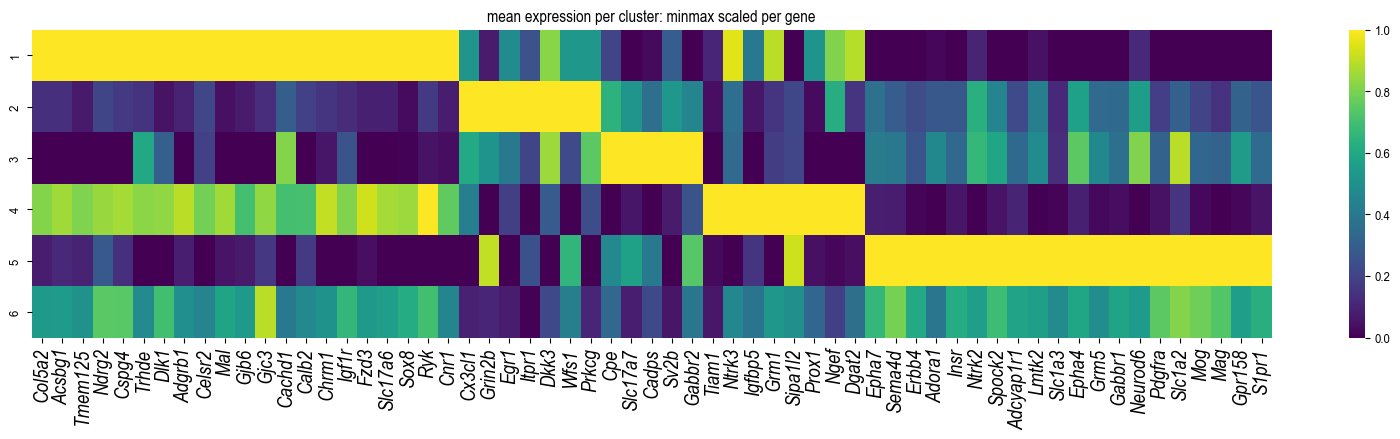

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.stretch'] = 'condensed'

############# heatmap visualization #######################
dat = m_norm_assign.copy()
nclusters = dat.shape[1]-3   # number of clusters is columns number - 3 (-1 cluster, gene, assigned_cluster columns)
dat1 = dat.sort_values(by='assigned_cluster',ascending=True)

###### min max scaling per cluster ####
v = np.transpose(np.array(dat1.iloc[:,1:(nclusters+1)]))  # grab clusters
v_normed = (v-v.min(axis=0)) / (v.max(axis=0)-v.min(axis=0))     # min max normalization per gene, highest cluster = 1, lowset = 0

######## plot ############
f = plt.figure(figsize=(20, 4))
xlabs = dat1['gene']
ylabs = np.array([*range(nclusters)])+1  # we will use 1 base system for labeling

ax = sns.heatmap(v_normed,cmap='viridis', xticklabels=xlabs,yticklabels=ylabs)
ax.set_xticklabels(ax.get_xticklabels(), size = 15)

ax.set_title('mean expression per cluster: minmax scaled per gene')

xLABs = ax.get_xticklabels()
for lbl in xLABs:
    lbl.set_style('italic')

plt.show()

   Index  Red  Green  Blue
0      0    0      0     0
1      1    0      0     7
2      2    0      0    15
3      3    0      0    22
4      4    0      0    30


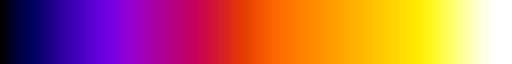

In [8]:
#################### plotting gene expression in umap and anatomical space #####################
### get a color map ####
from matplotlib.colors import ListedColormap

fire = pd.read_csv("./fire.csv")   # just a list of rgb
print(fire[:5])
fire_np = fire.iloc[:,1:4].to_numpy() # grab RGB
fire_cmap = ListedColormap(fire_np/255)
fire_cmap

(19871, 123) 19871


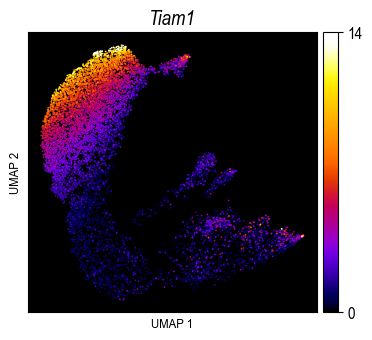

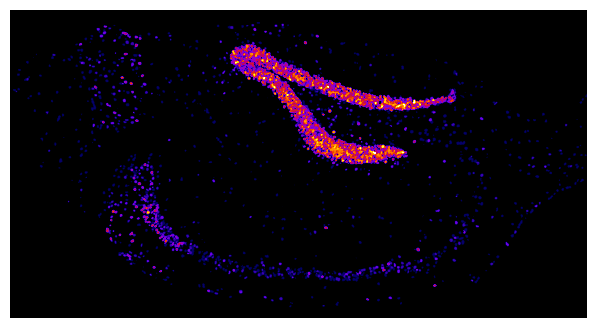

In [9]:
#################### plotting gene expression in umap and anatomical space #####################

f0 = plt.figure(figsize=(4, 4))

############### plot umap expression ###################
ax0 = f0.add_subplot(1,1,1)

# getting x,y,color values #
B = embedding_labels.clusters_swap >= 0 # only look at clustered cells
d = embedding_labels.loc[B,:].copy()
xval = d['UMAP 1'].to_numpy()
yval = d['UMAP 2'].to_numpy()
print(m.shape, len(B)) # make sure to use the unfiltered matrix, since B is boolean of clustered cells all cells
Gene = 'Tiam1'
expr = m[Gene][B].to_numpy()   # expression value of the gene
SORT = np.argsort(expr)   ## will be used to plot from low to high expression to ensure high expression cell doesn't get overlapped by low expression cell

# getting vmax to use for the plot #
expr_nonzero = expr[~(expr==0)]
#vMax = np.max(expr_nonzero) # use this if you want to use max of all data
vMax = np.percentile(expr_nonzero,99.8)  # only saturate 0.2 percent of nonzero data

# plot in umap space #
im0 = ax0.scatter(x=xval[SORT],y=yval[SORT],cmap=fire_cmap,
                  c=expr[SORT],
                  label=expr[SORT],s=1.5,
                  vmin=0,vmax=vMax,
                  linewidth=0)
ax0.set_facecolor('black') # black background, necessary for 'fire' heatmap

# make colorbar #
ax0_divider = make_axes_locatable(ax0)
ax0_divider = make_axes_locatable(ax0)
cax = ax0_divider.append_axes("right", size="5%", pad="2%")
cb = f.colorbar(im0, cax=cax,ticks=[0,vMax]) # only plot minmax values
cb.ax.tick_params(labelsize=12)

# do some aesthetics #
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_xlabel('UMAP 1')
ax0.set_ylabel('UMAP 2')
ax0.set_aspect(1)
ax0.set_title(Gene,fontsize=15,color='black',style='italic')

##########################################################################################################
############### plot tiff expression ###################
f1 = plt.figure(figsize=(10, 4))
ax1 = f1.add_subplot(1,1,1)

# get image that corrosponds to the gene #
# the image is segmentation data, where each segment/cell is given a value that matches the number of spots assigend to that cell
img = tifffile.imread("//nrs.hhmi.org/liu/HippoVisualization/GeneExpressionToCell/Hippo_gene_4.tiff")

z = 19 # select a z position

im1 = ax1.imshow(img[z,:,:],
                 cmap=fire_cmap,
                 vmin=im0.get_clim()[0], #use the same vmin as umap
                 vmax=im0.get_clim()[1]) #use the same vmax as umap
ax1.set_aspect(1.0)
ax1.set_axis_off()

############### save images #################
f0.patch.set_alpha(0.0)
f0.savefig("./hippo_umap_notebook/tiam1_umap.pdf",dpi=300)
f1.savefig("./hippo_umap_notebook/tiam1_hippo.pdf",dpi=300,transparent=True)
